<a href="https://colab.research.google.com/github/brandonkeung/Sepsis-Analysis/blob/main/Diagnosis_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler

In [11]:
df = pd.read_csv('Sepsis.csv')


# Male is 1 while Female is 0
df["gender"] = (df["gender"] == "M").astype(int)

# One-hot encoding for ethnicities
df['race_source_value'] = pd.factorize(df['race_source_value'])[0]

# randomly sample 10,000 data points
df = df.sample(n=10000)
top_disease = ["acute renal failure syndrome", "congestive heart failure", "atrial fibrillation", "essential hypertension", "urinary tract infectious disease"]

for disease in top_disease:
    df[disease] = df.apply(lambda row: 1 if disease.lower() in row["disease"].lower() else 0, axis=1)


seps = []
for d in df["disease"]:
    #print(d.lower())
    if "sepsis" in d.lower():
        seps.append(1)
    else:
        seps.append(0)

df["sepsis"] = seps

df = df.drop('disease', axis=1)
df = df.drop('person_id', axis=1)

df

,gender,race_source_value,acute renal failure syndrome,congestive heart failure,atrial fibrillation,essential hypertension,urinary tract infectious disease,sepsis
4755,0,0,0,0,0,0,0,0
3561,1,0,0,0,0,0,0,0
35763,0,0,0,0,1,1,0,0
29091,1,0,0,0,1,1,0,0
42750,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
23235,0,0,1,0,0,0,0,1
11052,0,0,0,0,0,0,0,0
8970,1,0,0,0,1,0,0,1
15569,1,0,0,0,0,0,0,0


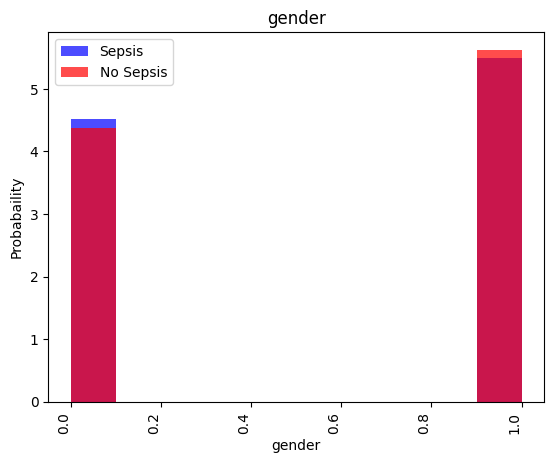

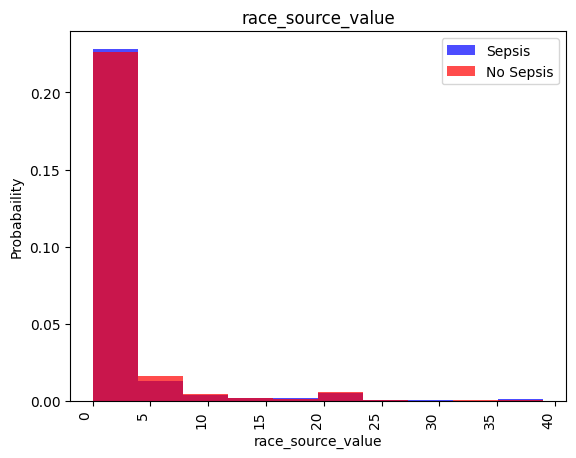

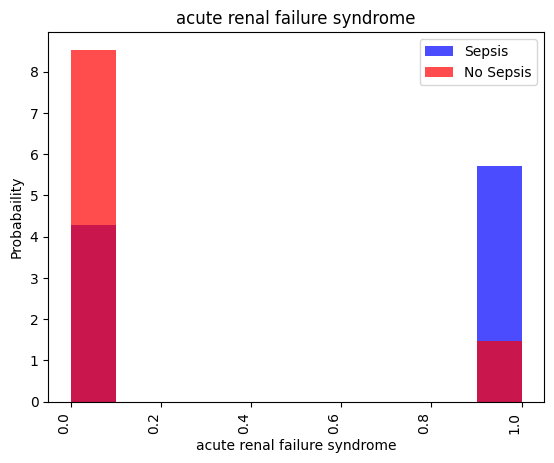

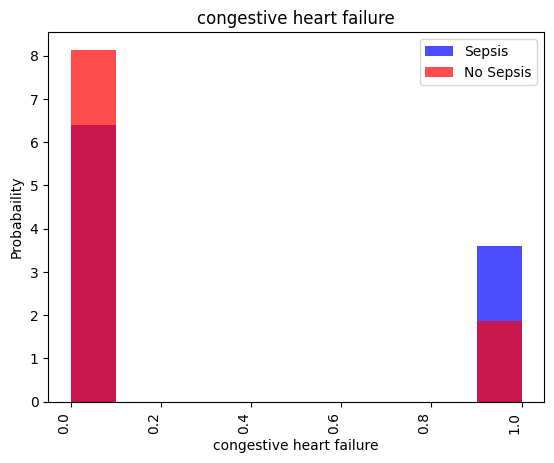

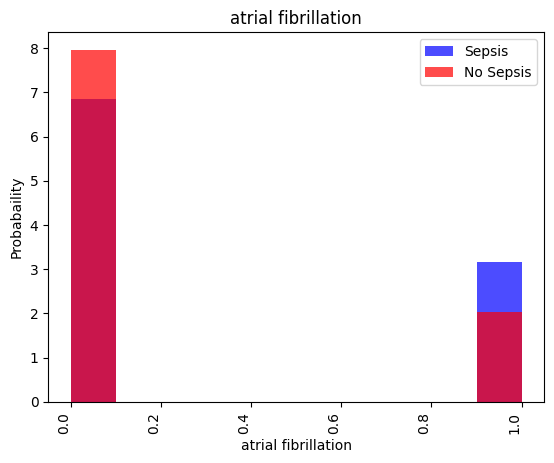

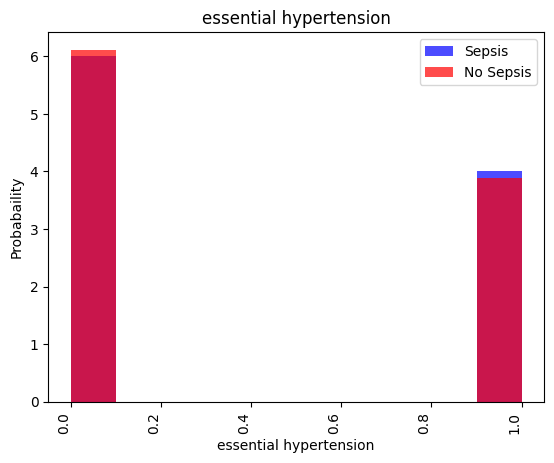

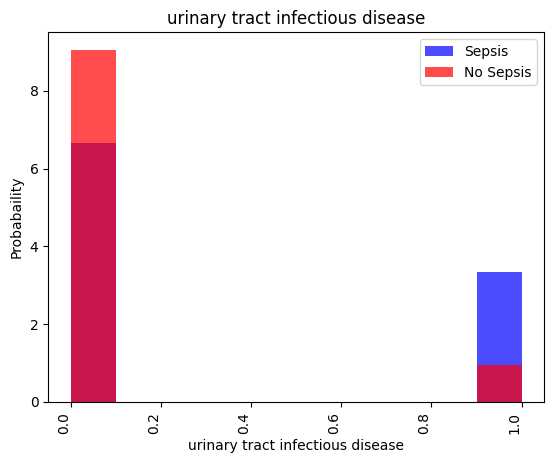

In [12]:
for label in cols[:-1]:
  plt.hist(df[df["sepsis"]==1][label], color='blue', label='Sepsis', alpha=0.7, density=True)
  plt.hist(df[df["sepsis"] == 0][label], color='red', label='No Sepsis', alpha=0.7, density=True)
  plt.title(label)
  plt.ylabel("Probabaility")
  plt.xlabel(label)
  plt.xticks(rotation=90, ha='right')
  plt.legend()
  plt.show()

In [13]:
# segments portions of dat as train, valid, and test
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [14]:
# scales inputs so that they are relative to mean and standrad deviation of specific columns
# note: upper case variable name refers to matrices while lower case variable names refer to 1D arrays
# oversample=True makes it so equal amounts of gamma and hadron are in the training datasets
def scale_dataset(dataframe, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    # Convert labels to integers
    le = LabelEncoder()
    y = le.fit_transform(y)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (len(y), 1))))

    return data, X, y

In [15]:
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=True)
# do not want to oversample because want to see if our model is accurate
test, X_test, y_test = scale_dataset(test, oversample=False) 

#KNN Model


In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

In [17]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model = knn_model.fit(X_train, y_train)

In [18]:
y_pred = knn_model.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.22      0.35      1725
           1       0.14      0.79      0.24       275

    accuracy                           0.30      2000
   macro avg       0.50      0.50      0.29      2000
weighted avg       0.77      0.30      0.33      2000



In [20]:
print(accuracy_score(y_test, y_pred))

0.297


In [21]:
print(roc_auc_score(y_test, y_pred))

0.5038208168642951


#Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
clf = RandomForestClassifier(max_depth=3)

In [24]:
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=3)

In [25]:
y_pred = clf.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.77      0.84      1725
           1       0.32      0.68      0.43       275

    accuracy                           0.75      2000
   macro avg       0.63      0.72      0.64      2000
weighted avg       0.85      0.75      0.79      2000



In [27]:
clf.feature_importances_

array([0.00603479, 0.00789016, 0.53575835, 0.11848785, 0.03946779,
       0.00524106, 0.28711999])

#SVM Model


In [28]:
from sklearn.svm import SVC

In [29]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

In [30]:

y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1725
           1       0.32      0.64      0.43       275

    accuracy                           0.77      2000
   macro avg       0.63      0.71      0.64      2000
weighted avg       0.85      0.77      0.79      2000



#Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression 

In [32]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

In [33]:
y_pred = lg_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1725
           1       0.33      0.65      0.43       275

    accuracy                           0.77      2000
   macro avg       0.63      0.72      0.64      2000
weighted avg       0.85      0.77      0.80      2000



In [34]:
lg_model.coef_

array([[ 0.0010912 , -0.00860153,  0.77132045,  0.14286152,  0.08242608,
        -0.13548339,  0.41877845]])

#Neural Network

In [35]:
import tensorflow as tf

In [36]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Binary crossentropy')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

# combination of the above two functions
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [37]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(7,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )

  return nn_model, history

16 nodes, dropout 0, lr 0.005, batch size 32


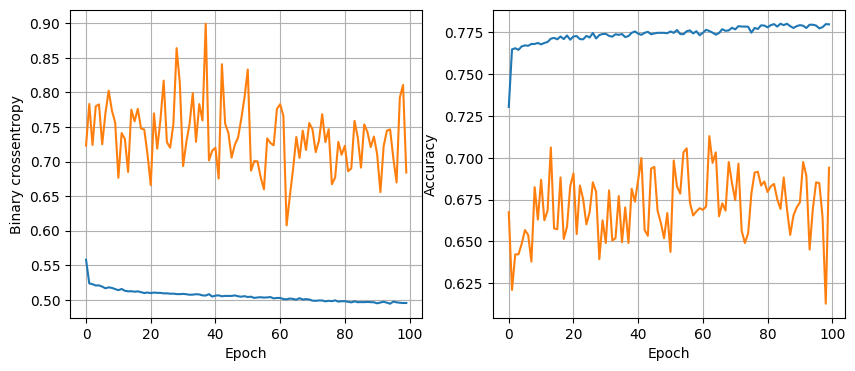

111/111 [==============================] - 0s 2ms/step - loss: 0.6401 - accuracy: 0.7073
16 nodes, dropout 0, lr 0.005, batch size 64


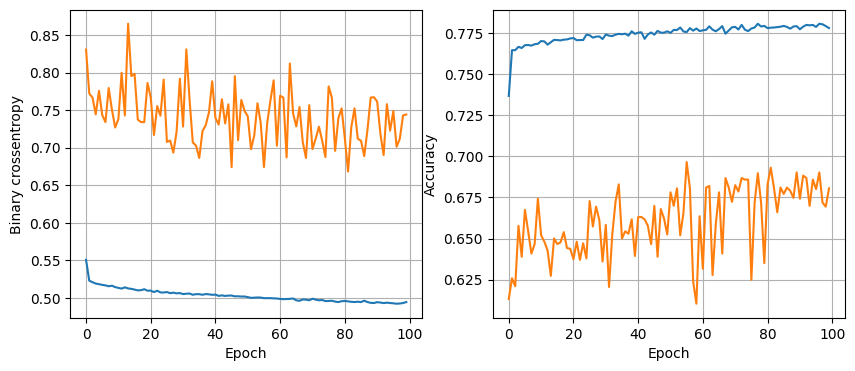

111/111 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.7045
16 nodes, dropout 0, lr 0.005, batch size 128


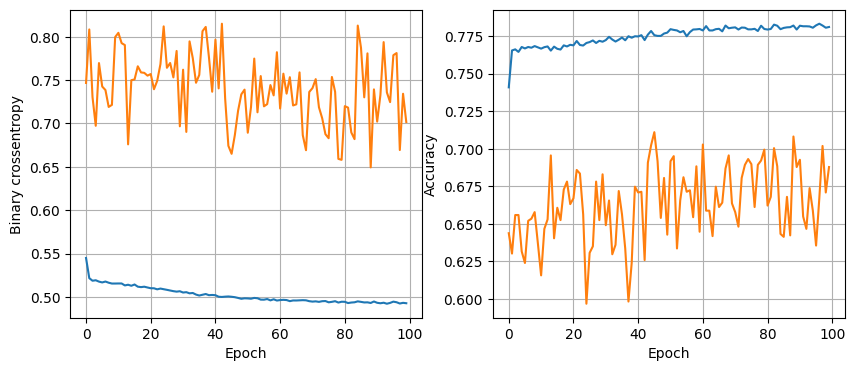

111/111 [==============================] - 0s 4ms/step - loss: 0.7139 - accuracy: 0.6943
16 nodes, dropout 0, lr 0.001, batch size 32


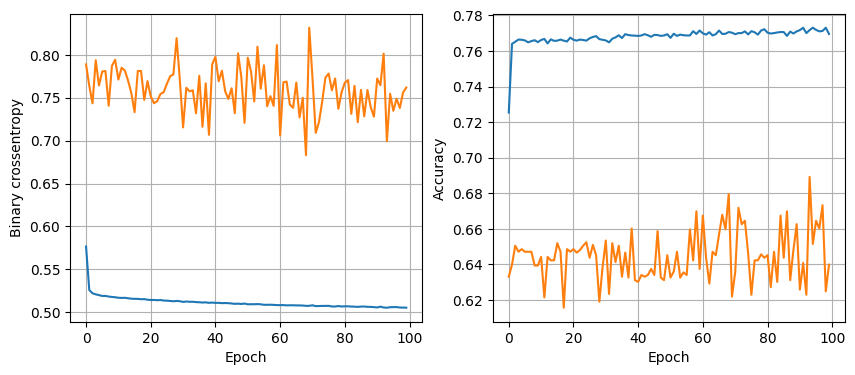

111/111 [==============================] - 0s 2ms/step - loss: 0.6202 - accuracy: 0.7118
16 nodes, dropout 0, lr 0.001, batch size 64


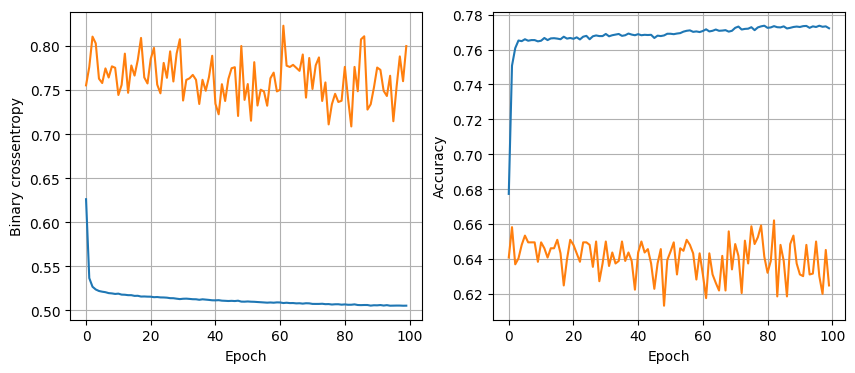

111/111 [==============================] - 0s 2ms/step - loss: 0.6219 - accuracy: 0.6943
16 nodes, dropout 0, lr 0.001, batch size 128


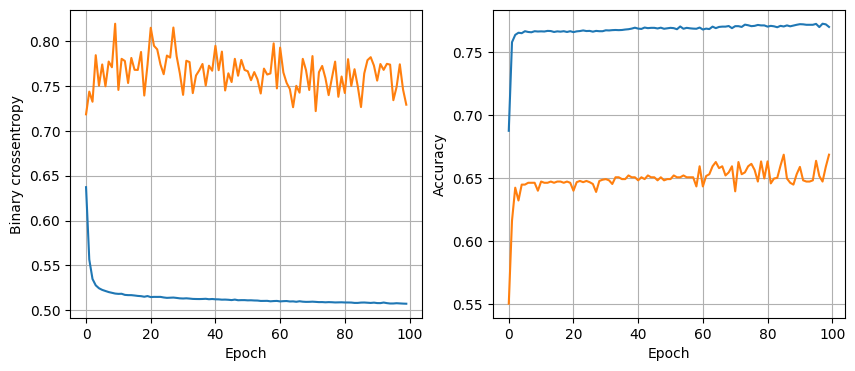

111/111 [==============================] - 0s 2ms/step - loss: 0.5971 - accuracy: 0.7195
16 nodes, dropout 0.2, lr 0.005, batch size 32


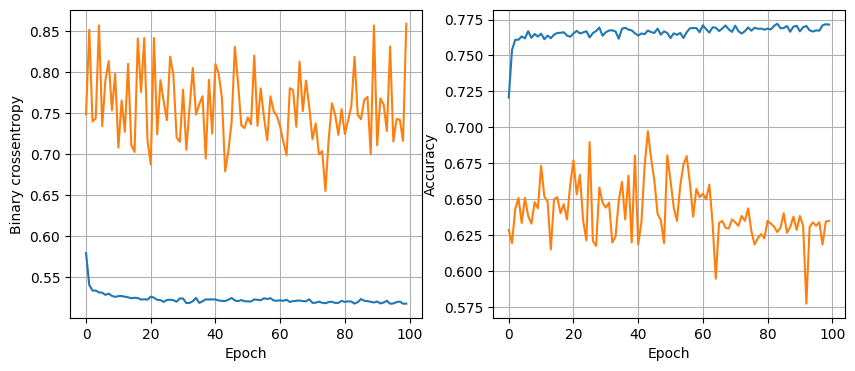

111/111 [==============================] - 0s 2ms/step - loss: 0.6374 - accuracy: 0.7008
16 nodes, dropout 0.2, lr 0.005, batch size 64


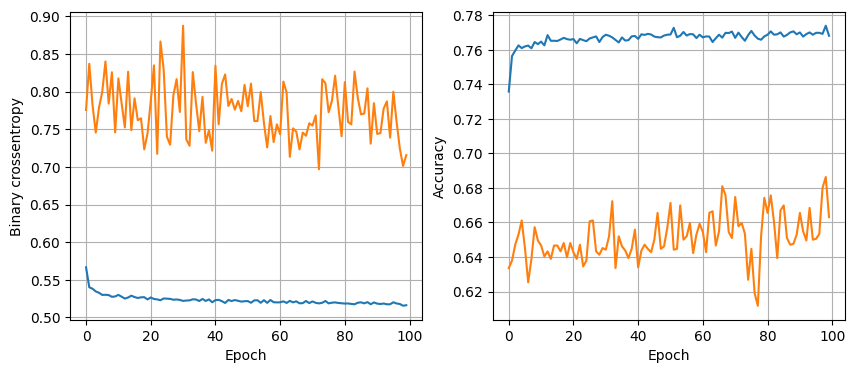

111/111 [==============================] - 0s 2ms/step - loss: 0.5884 - accuracy: 0.7186
16 nodes, dropout 0.2, lr 0.005, batch size 128


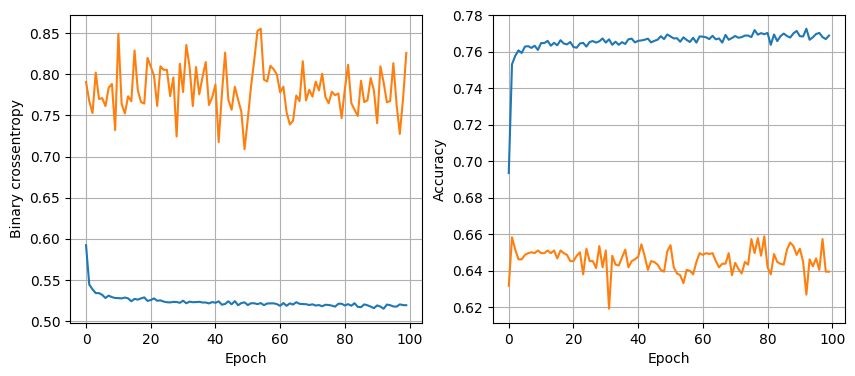

111/111 [==============================] - 0s 2ms/step - loss: 0.6172 - accuracy: 0.7107
16 nodes, dropout 0.2, lr 0.001, batch size 32


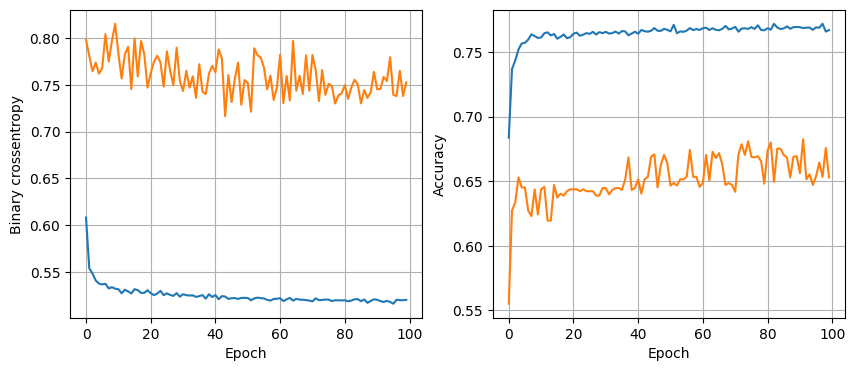

111/111 [==============================] - 0s 2ms/step - loss: 0.5974 - accuracy: 0.7183
16 nodes, dropout 0.2, lr 0.001, batch size 64


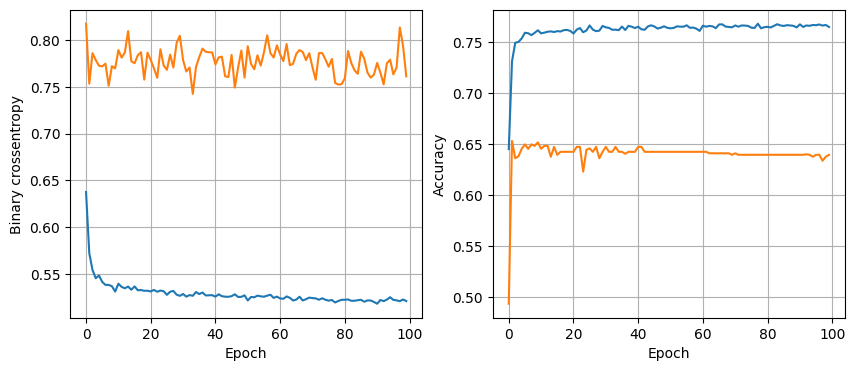

111/111 [==============================] - 0s 2ms/step - loss: 0.5908 - accuracy: 0.7189
16 nodes, dropout 0.2, lr 0.001, batch size 128


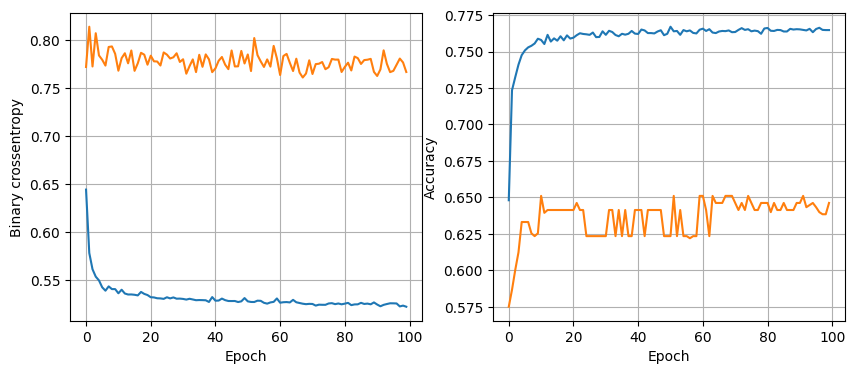

111/111 [==============================] - 0s 2ms/step - loss: 0.5866 - accuracy: 0.7265
32 nodes, dropout 0, lr 0.005, batch size 32


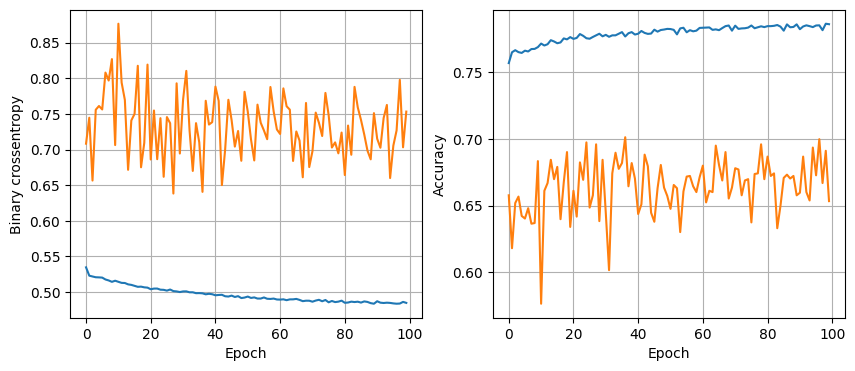

111/111 [==============================] - 0s 2ms/step - loss: 0.7852 - accuracy: 0.6917
32 nodes, dropout 0, lr 0.005, batch size 64


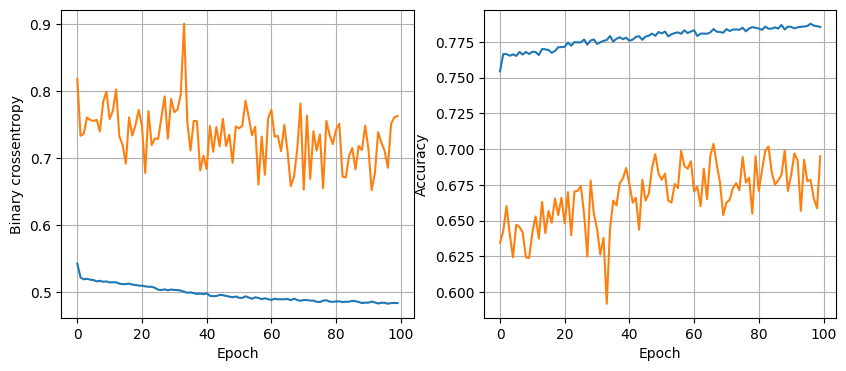

111/111 [==============================] - 0s 2ms/step - loss: 0.7780 - accuracy: 0.6906
32 nodes, dropout 0, lr 0.005, batch size 128


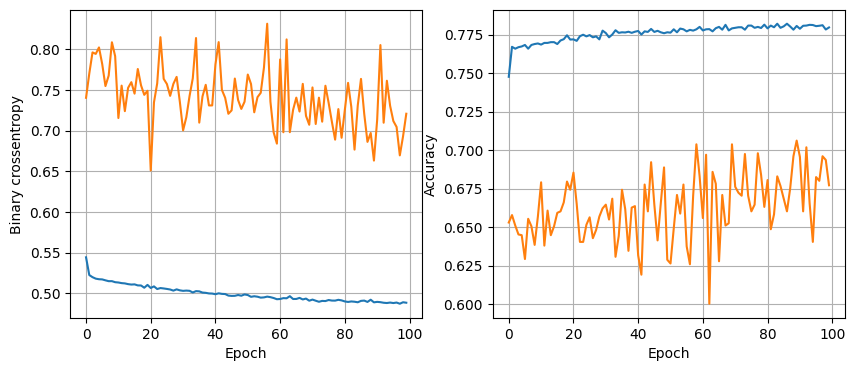

111/111 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.7005
32 nodes, dropout 0, lr 0.001, batch size 32


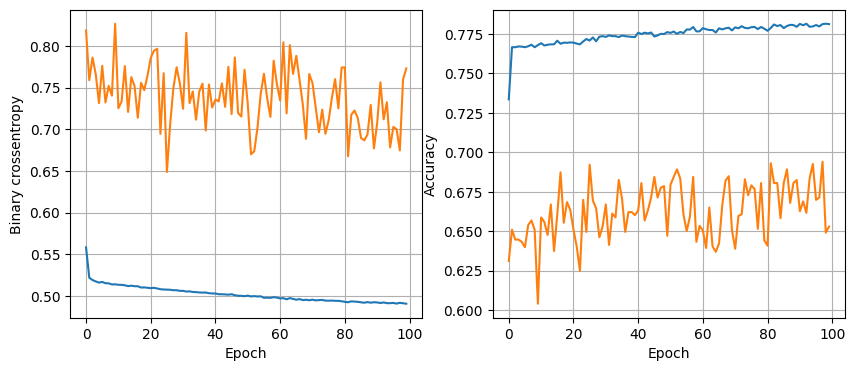

111/111 [==============================] - 0s 2ms/step - loss: 0.7004 - accuracy: 0.6756
32 nodes, dropout 0, lr 0.001, batch size 64


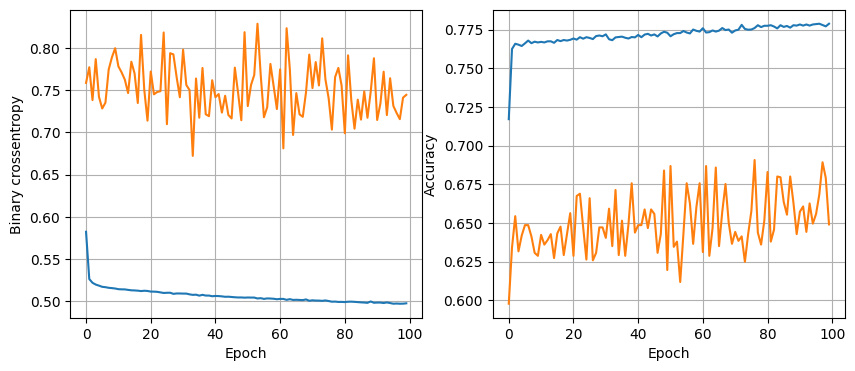

111/111 [==============================] - 0s 2ms/step - loss: 0.6367 - accuracy: 0.7019
32 nodes, dropout 0, lr 0.001, batch size 128


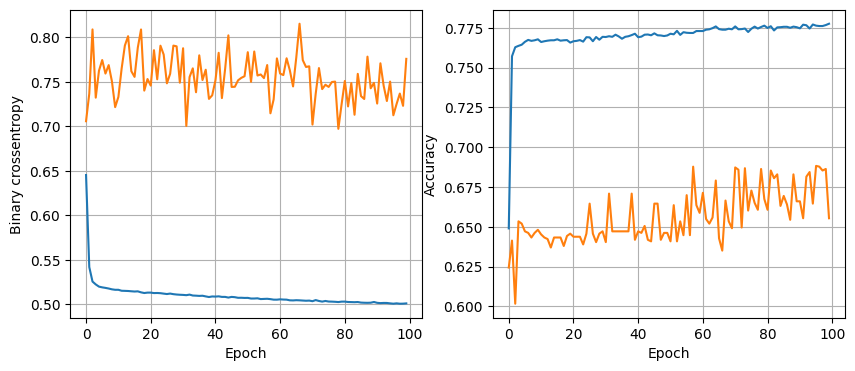

111/111 [==============================] - 0s 2ms/step - loss: 0.6346 - accuracy: 0.7005
32 nodes, dropout 0.2, lr 0.005, batch size 32


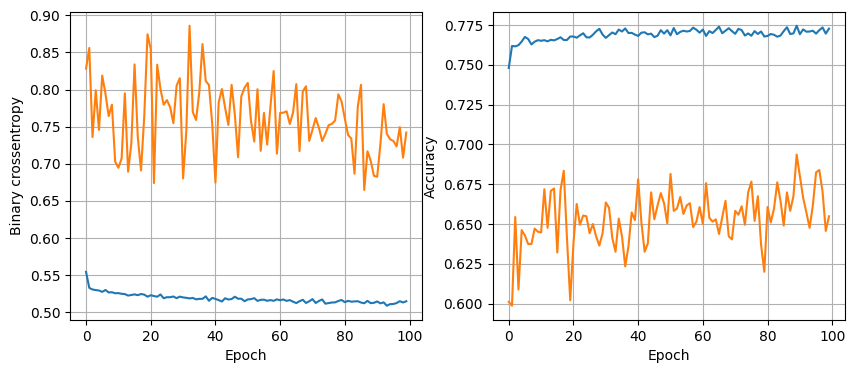

111/111 [==============================] - 0s 2ms/step - loss: 0.6152 - accuracy: 0.7132
32 nodes, dropout 0.2, lr 0.005, batch size 64


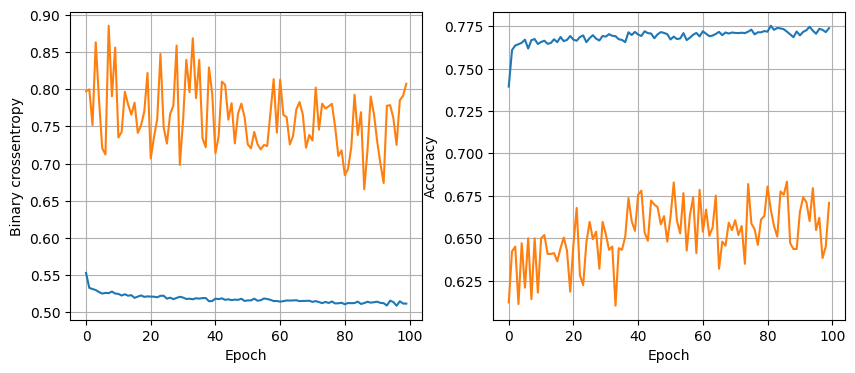

111/111 [==============================] - 0s 2ms/step - loss: 0.6272 - accuracy: 0.7042
32 nodes, dropout 0.2, lr 0.005, batch size 128


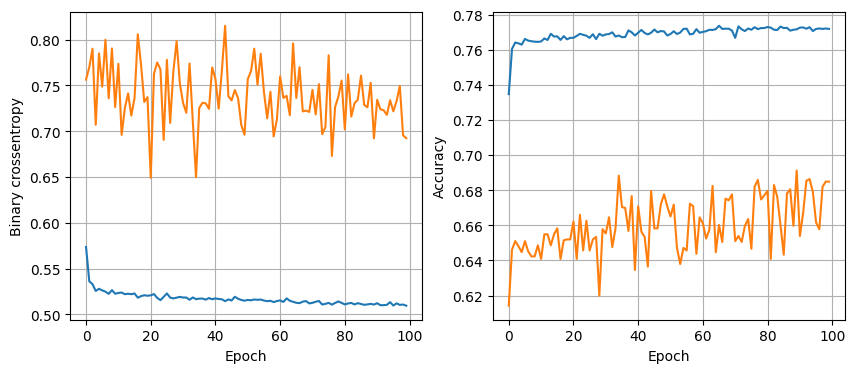

111/111 [==============================] - 0s 2ms/step - loss: 0.6021 - accuracy: 0.7180
32 nodes, dropout 0.2, lr 0.001, batch size 32


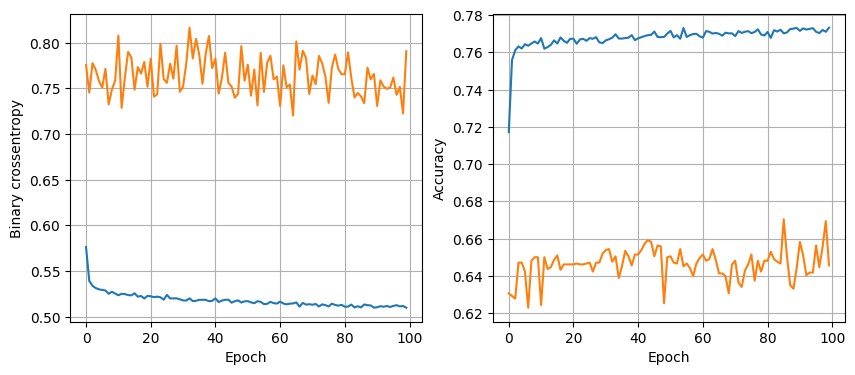

111/111 [==============================] - 0s 2ms/step - loss: 0.6177 - accuracy: 0.7073
32 nodes, dropout 0.2, lr 0.001, batch size 64


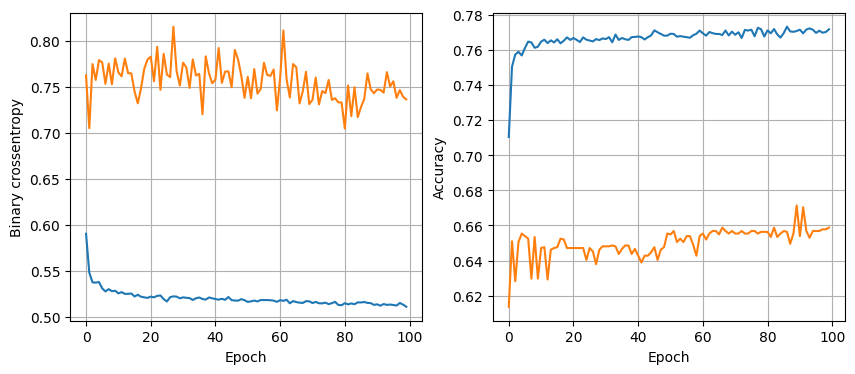

111/111 [==============================] - 0s 2ms/step - loss: 0.6080 - accuracy: 0.7098
32 nodes, dropout 0.2, lr 0.001, batch size 128


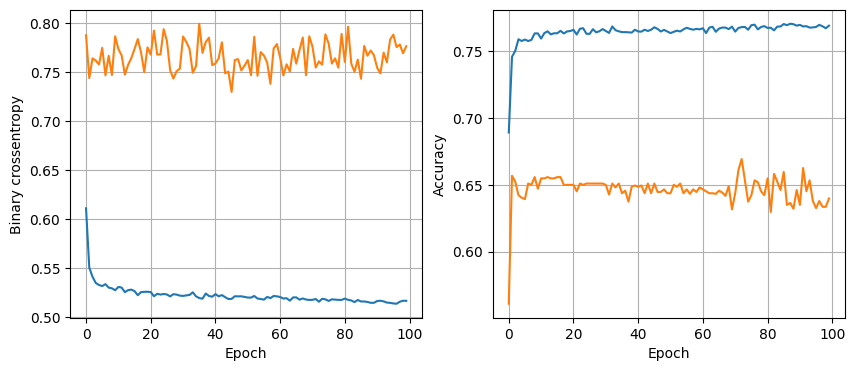

111/111 [==============================] - 0s 3ms/step - loss: 0.5986 - accuracy: 0.7132


In [38]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [16, 32]:
  for dropout_prob in[0, 0.2]:
    for lr in [0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
        model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(X_valid, y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model

In [39]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,) # flatten into 1D array

63/63 [==============================] - 0s 2ms/step


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86      1725
           1       0.33      0.60      0.43       275

    accuracy                           0.78      2000
   macro avg       0.63      0.70      0.65      2000
weighted avg       0.85      0.78      0.80      2000



#XGBoost


In [41]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [42]:
classifier = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3
    )

In [43]:
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [44]:
y_pred = classifier.predict(X_test)

In [45]:
mean_squared_error(y_pred, y_test)

0.235

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1725
           1       0.32      0.64      0.43       275

    accuracy                           0.77      2000
   macro avg       0.63      0.71      0.64      2000
weighted avg       0.85      0.77      0.79      2000



In [47]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

In [48]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [49]:
pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns=df.columns[:-1])

,gender,race_source_value,acute renal failure syndrome,congestive heart failure,atrial fibrillation,essential hypertension,urinary tract infectious disease
0,0.03414,0.013829,0.635365,0.054549,0.028737,0.023504,0.209876


In [50]:
y_pred = regressor.predict(X_test)

In [51]:
mean_squared_error(y_test, y_pred)

0.1883012604096879

In [52]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,) # flatten into 1D array

63/63 [==============================] - 0s 1ms/step


In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86      1725
           1       0.33      0.60      0.43       275

    accuracy                           0.78      2000
   macro avg       0.63      0.70      0.65      2000
weighted avg       0.85      0.78      0.80      2000



In [54]:
pd.DataFrame(classifier.feature_importances_.reshape(1, -1), columns=df.columns[:-1])

,gender,race_source_value,acute renal failure syndrome,congestive heart failure,atrial fibrillation,essential hypertension,urinary tract infectious disease
0,0.032312,0.009467,0.647829,0.051009,0.022803,0.03057,0.20601
